# Problem Definition

The dataset offers vast number of patient-related information including pre-conditions. It consists of 21 features and the sample size is bigger than 1.000.000 unique patients. 
We want to predict whether a patient has a high chance of death, considering his pre-conditions.

# Importing Libraries and Reading Data

In [682]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [683]:
df = pd.read_csv("coviddata.csv", sep=",")

# Preparation

### Exploration

In [684]:
#show a summary of the dataset
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


What stands out is, that the binary features use 1 and 2 instead of 1 and 0. We will have to work on that. The other problem is that the label data "DATE_DIED" is non-binary and instead either uses the data of death or a not-dead code "9999-99-99". We will also fix this.

In [685]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

As can be seen with the "df.info()" command, the supposed binary features are instead integers. The label is an object. This has to be fixed.
In addition to that, multiple features are post-conditional. Thus we will remove features like "PATIENT_TYPE" (type of care the patient received in the unit. 1 for returned home and 2 for hospitalization), "INTUBED" (whether the patient was connected to the ventilator), "MEDICAL_UNIT" (type of institution of the National Health System that provided the care.), "USMER" (Indicates whether the patient treated medical units of the first, second or third level.), "ICU" (whether the patient had been admitted to an Intensive Care Unit) and "CLASSIFICATION_FINAL" (Covid test results. see data description).

### Cleaning

In [686]:
number_nan = df.isna().sum().sum()
print(f"Total number of null values: {number_nan}")

Total number of null values: 0


For now we will remove the features noted above, since they are not applicable for the determined model.

In [687]:
df = df.drop(["PATIENT_TYPE", "INTUBED", "MEDICAL_UNIT", "USMER", "ICU", "CLASIFFICATION_FINAL"], axis = 1)

Since checking for outliers on this dataset in necessary, we will now correct the formatting issues noted above.

In [688]:
for i in df.columns:
   print(i)
   print(f"{df[i].value_counts()} \n ----------")

SEX
1    525064
2    523511
Name: SEX, dtype: int64 
 ----------
DATE_DIED
9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: DATE_DIED, Length: 401, dtype: int64 
 ----------
PNEUMONIA
2     892534
1     140038
99     16003
Name: PNEUMONIA, dtype: int64 
 ----------
AGE
30     27010
31     25927
28     25313
29     25134
34     24872
       ...  
114        2
116        2
111        1
121        1
113        1
Name: AGE, Length: 121, dtype: int64 
 ----------
PREGNANT
97    523511
2     513179
1       8131
98      3754
Name: PREGNANT, dtype: int64 
 ----------
DIABETES
2     920248
1     124989
98      3338
Name: DIABETES, dtype: int64 
 ----------
COPD
2     1030510
1       15062
98       3003
Name: COPD, dtype: int64 
 ----------
ASTHMA
2     1014024
1       31572
98       2979
Name: ASTHMA, dtype: i

It seems like the dataset is free of null values, but this isn't quite the case. When reading the dataset comment you can see that the authors have denoted missing data with the integer-codes "97" and "99". Thus, we will transform all 97 and 99 values to null values and then remove all rows containing null values. We will leave out the age group, since those values are real ages.

One thing that stands out is, that the "PREGNANT" feature has more than half-a-million entries in the 97 missing data category. When checking the data information we can see that those 97 values are simply the men and the 1 and 2 are just the women which are pregnant or not pregnant. We will adjust this and not remove these 97 values.

In [689]:
# create new df for features where we dont want to drop 97 and 99 values
df_removal = df.drop(["AGE", "PREGNANT"], axis = 1)

# Apply the function to all columns of the dataframe
df_removal = df_removal.replace({97: pd.np.nan, 99: pd.np.nan, 98: pd.np.nan})

# adjust the pregnant feature
df_pregnant = df["PREGNANT"]
df_pregnant = df_pregnant.replace(97, 2)
df_pregnant = df_pregnant.replace(98, pd.np.nan)

print(df_pregnant.value_counts())

C:\Users\Nils\AppData\Local\Temp\ipykernel_19036\2777721311.py:5: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



2.0    1036690
1.0       8131
Name: PREGNANT, dtype: int64


C:\Users\Nils\AppData\Local\Temp\ipykernel_19036\2777721311.py:10: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



In [690]:
# combine the whole data back together
df = pd.concat([df_removal, df_pregnant, df["AGE"]], axis = 1)
df


,SEX,DATE_DIED,PNEUMONIA,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,PREGNANT,AGE
0,1,03/05/2020,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,65
1,2,03/06/2020,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,72
2,2,09/06/2020,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,55
3,1,12/06/2020,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,53
4,2,21/06/2020,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,9999-99-99,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,40
1048571,2,9999-99-99,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,51
1048572,2,9999-99-99,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,55
1048573,2,9999-99-99,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,28


In [691]:
number_nan = df.isna().sum().sum()
print(f"Total number of null values: {number_nan}")

Total number of null values: 52964


We can see that the total number of null values is much higher than the first look has made it seem. We will drop all rows which contain null values.

In [692]:
df = df.dropna()
df.shape

(1021977, 15)

We have now dropped only 50k of 1mil samples and removed 6 features.

Next we continue with our formatting issues. We now have to transform the integer-data to binary-data.

In [693]:
for i in df.columns:
   print(i)
   print(f"{df[i].value_counts()} \n ----------")

SEX
2    511936
1    510041
Name: SEX, dtype: int64 
 ----------
DATE_DIED
9999-99-99    947320
06/07/2020       984
07/07/2020       981
13/07/2020       969
16/06/2020       965
               ...  
27/02/2021         1
26/02/2021         1
20/02/2021         1
11/02/2021         1
22/04/2021         1
Name: DATE_DIED, Length: 395, dtype: int64 
 ----------
PNEUMONIA
2.0    884614
1.0    137363
Name: PNEUMONIA, dtype: int64 
 ----------
DIABETES
2.0    899805
1.0    122172
Name: DIABETES, dtype: int64 
 ----------
COPD
2.0    1007619
1.0      14358
Name: COPD, dtype: int64 
 ----------
ASTHMA
2.0    991561
1.0     30416
Name: ASTHMA, dtype: int64 
 ----------
INMSUPR
2.0    1008419
1.0      13558
Name: INMSUPR, dtype: int64 
 ----------
HIPERTENSION
2.0    862715
1.0    159262
Name: HIPERTENSION, dtype: int64 
 ----------
OTHER_DISEASE
2.0    994893
1.0     27084
Name: OTHER_DISEASE, dtype: int64 
 ----------
CARDIOVASCULAR
2.0    1001891
1.0      20086
Name: CARDIOVASCULAR, dtype: i

In [694]:
# transform all 2 values to 0 (not age and date_died category)
df_binarized = df.drop(["AGE", "DATE_DIED"], axis = 1)
df_binarized = df_binarized.replace(2, 0)

for i in df_binarized.columns:
   print(i)
   print(f"{df_binarized[i].value_counts()} \n ----------")

SEX
0    511936
1    510041
Name: SEX, dtype: int64 
 ----------
PNEUMONIA
0.0    884614
1.0    137363
Name: PNEUMONIA, dtype: int64 
 ----------
DIABETES
0.0    899805
1.0    122172
Name: DIABETES, dtype: int64 
 ----------
COPD
0.0    1007619
1.0      14358
Name: COPD, dtype: int64 
 ----------
ASTHMA
0.0    991561
1.0     30416
Name: ASTHMA, dtype: int64 
 ----------
INMSUPR
0.0    1008419
1.0      13558
Name: INMSUPR, dtype: int64 
 ----------
HIPERTENSION
0.0    862715
1.0    159262
Name: HIPERTENSION, dtype: int64 
 ----------
OTHER_DISEASE
0.0    994893
1.0     27084
Name: OTHER_DISEASE, dtype: int64 
 ----------
CARDIOVASCULAR
0.0    1001891
1.0      20086
Name: CARDIOVASCULAR, dtype: int64 
 ----------
OBESITY
0.0    865383
1.0    156594
Name: OBESITY, dtype: int64 
 ----------
RENAL_CHRONIC
0.0    1003657
1.0      18320
Name: RENAL_CHRONIC, dtype: int64 
 ----------
TOBACCO
0.0    939439
1.0     82538
Name: TOBACCO, dtype: int64 
 ----------
PREGNANT
0.0    1014136
1.0       

In [695]:
# adjust the date_died category
df_died = df["DATE_DIED"]
df_died = df_died.replace("9999-99-99", 0)

df_died = df_died.where(df_died.eq(0), 1)

df_died

0          1
1          1
2          1
3          1
4          1
          ..
1048570    0
1048571    0
1048572    0
1048573    0
1048574    0
Name: DATE_DIED, Length: 1021977, dtype: object

We transformed all data the way we wanted it. No we only have to change its datatype to boolean instead of the current integer.

In [696]:
# transform to boolean
df_died = df_died.astype(bool)
df_binarized = df_binarized.astype(bool)

# combine back to one df
df = pd.concat([df_died, df_binarized, df["AGE"]], axis = 1)

# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021977 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   DATE_DIED       1021977 non-null  bool 
 1   SEX             1021977 non-null  bool 
 2   PNEUMONIA       1021977 non-null  bool 
 3   DIABETES        1021977 non-null  bool 
 4   COPD            1021977 non-null  bool 
 5   ASTHMA          1021977 non-null  bool 
 6   INMSUPR         1021977 non-null  bool 
 7   HIPERTENSION    1021977 non-null  bool 
 8   OTHER_DISEASE   1021977 non-null  bool 
 9   CARDIOVASCULAR  1021977 non-null  bool 
 10  OBESITY         1021977 non-null  bool 
 11  RENAL_CHRONIC   1021977 non-null  bool 
 12  TOBACCO         1021977 non-null  bool 
 13  PREGNANT        1021977 non-null  bool 
 14  AGE             1021977 non-null  int64
dtypes: bool(14), int64(1)
memory usage: 29.2 MB


Everything seems to have worked out perfectly.

The cleaning is now complete.

In [697]:
df

,DATE_DIED,SEX,PNEUMONIA,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,PREGNANT,AGE
0,True,True,True,False,False,False,False,True,False,False,False,False,False,False,65
1,True,False,True,False,False,False,False,True,False,False,True,True,False,False,72
2,True,False,False,True,False,False,False,False,False,False,False,False,False,False,55
3,True,True,False,False,False,False,False,False,False,False,False,False,False,False,53
4,True,False,False,True,False,False,False,True,False,False,False,False,False,False,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,False,False,False,False,False,False,False,False,False,False,False,False,False,False,40
1048571,False,False,False,False,False,False,False,True,False,False,False,False,False,False,51
1048572,False,False,False,False,False,False,False,False,False,False,False,False,False,False,55
1048573,False,False,False,False,False,False,False,False,False,False,False,False,False,False,28


### Splitting the Data

In [698]:
from sklearn.model_selection import train_test_split

X = df.drop('DATE_DIED',axis=1)
y = df['DATE_DIED']

### Imbalance

In [699]:
df["DATE_DIED"].value_counts()

False    947320
True      74657
Name: DATE_DIED, dtype: int64

In [700]:
# Undersample the FALSE DATE_DIED label
from imblearn.under_sampling import RandomUnderSampler

# Create the undersampling object
undersampler = RandomUnderSampler()

# Apply the undersampling to the data
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

y = y_undersampled
X = X_undersampled

X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.25)

print(len(X_undersampled))
print(len(y_undersampled))

149314
149314


# Data Visualization

<AxesSubplot:>

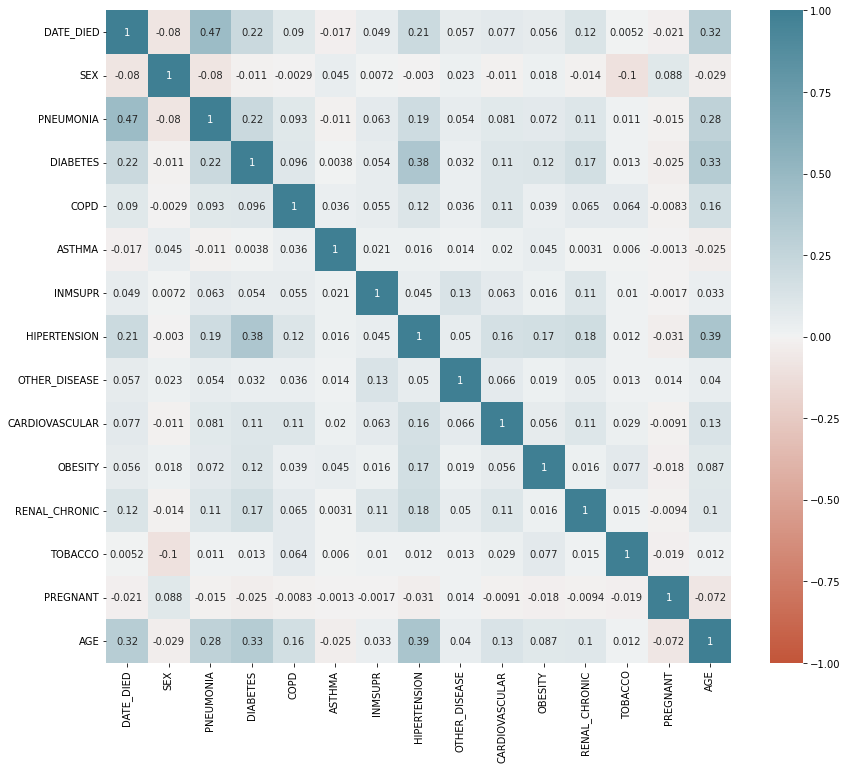

In [701]:
fig, ax = plt.subplots(figsize=(14,12))

sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), annot=True)

# Algorithm Architecture

We will the XGBClassification as our algorithm of choice.

In [702]:
import xgboost as xgb
from xgboost import XGBClassifier

# Create the model
model = xgb.XGBClassifier(max_depth=4, n_estimators=200, subsample=1, min_child_weight=0, gamma=5, max_delta_step=1.25, colsample_bytree=0.25, scale_pos_weight=1.05, learning_rate=0.2)

# Fine-Tuning

In [703]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

feature_1 = "learning_rate"
feature_2 = "scale_pos_weight"

feature_1_values = np.linspace(0.01, 0.5, 10)
feature_2_values = np.linspace(0, 1.2, 10)

# We will always check 3 parameters at a time and keep adjusting
# feature_1: feature_1_values, feature_2: feature_2_values
param_grid = {}

# Create a grid search object
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", verbose=2, cv=10)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.0s


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.25,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=5, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=1.25, max_depth=4,
                                     max_leaves=None, min_child_weight=0,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={}, scoring='accuracy', verbose=2)

In [704]:
# See best parameter combination
grid_search.best_params_

{}

# Training the Model

In [705]:
best_model = grid_search.best_estimator_

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = best_model.predict(X_test)

# Evaluating the Model

### Report

In [713]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

       False       0.87      0.84      0.86     18693
        True       0.84      0.88      0.86     18636

    accuracy                           0.86     37329
   macro avg       0.86      0.86      0.86     37329
weighted avg       0.86      0.86      0.86     37329



### ROC AUC

ROC AUC: 0.8579134701279829


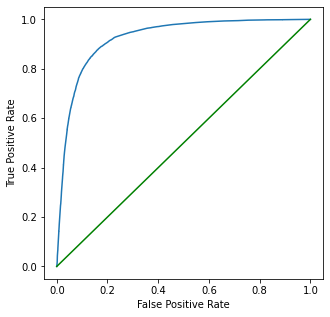

In [707]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

y_proba = best_model.predict_proba(X_test)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, predictions)
print("ROC AUC:", roc_auc)

def plot_sklearn_roc_curve(y_real, predictions):
    fpr, tpr, _ = roc_curve(y_real, predictions)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
    
# Plots the ROC curve using the sklearn methods - Good plot
plot_sklearn_roc_curve(y_test, y_proba[:, 1])

# Hyperparamter Contour Graphs

In [708]:
import pandas as pd

grid_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_results.head()

,Accuracy
0,0.85607


In [709]:
grid_contour = grid_results.groupby([feature_1,feature_2]).mean()
grid_contour

KeyError: 'learning_rate'

In [ ]:
grid_reset = grid_contour.reset_index()
grid_reset.columns = [feature_1, feature_2, 'Accuracy']
grid_pivot = grid_reset.pivot(feature_1, feature_2)
grid_pivot

Accuracy                                                    \
scale_pos_weight 0.000000  0.133333  0.266667  0.400000  0.533333  0.666667   
learning_rate                                                                 
0.010000          0.49954  0.526972  0.682716  0.764147  0.804938  0.829674   
0.064444          0.49954  0.735215  0.798696  0.822315  0.838478  0.848221   
0.118889          0.49954  0.743242  0.802170  0.827825  0.843158  0.850542   
0.173333          0.49954  0.747511  0.804831  0.828924  0.843524  0.851034   
0.227778          0.49954  0.749716  0.805036  0.829531  0.843756  0.851114   
0.282222          0.49954  0.745305  0.804751  0.830602  0.844024  0.850855   
0.336667          0.49954  0.747779  0.806394  0.830852  0.843899  0.850614   
0.391111          0.49954  0.747520  0.805144  0.830924  0.844479  0.851203   
0.445556          0.49954  0.746511  0.805019  0.829540  0.844488  0.851498   
0.500000          0.49954  0.745743  0.805402  0.830567  0.844399  0.851739   

                                                          
scale_pos_weight  0.800000  0.933333  1.066667  1.200000  
learning_rate                                             
0.010000          0.840121  0.846113  0.852159  0.850757  
0.064444          0.853132  0.855329  0.856302  0.856052  
0.118889          0.854579  0.856418  0.856516  0.856213  
0.173333          0.854918  0.856704  0.856793  0.856543  
0.227778          0.854739  0.856356  0.856418  0.856436  
0.282222          0.855132  0.856311  0.856543  0.856695  
0.336667          0.854525  0.856472  0.856302  0.856249  
0.391111          0.854748  0.856249  0.856579  0.856516  
0.445556          0.855097  0.856534  0.856409  0.856159  
0.500000          0.855266  0.856418  0.856391  0.856097

In [ ]:
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

In [ ]:
import plotly.graph_objects as go

# X and Y axes labels
layout = go.Layout(
            xaxis=go.layout.XAxis(
              title=go.layout.xaxis.Title(
              text=feature_2)
             ),
             yaxis=go.layout.YAxis(
              title=go.layout.yaxis.Title(
              text=feature_1) 
            ) )

fig = go.Figure(data = [go.Contour(z=z, x=x, y=y)], layout=layout )

fig.update_layout(title='Hyperparameter tuning', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
import plotly.graph_objects as go


fig = go.Figure(data= [go.Surface(z=z, y=y, x=x)], layout=layout )
fig.update_layout(title='Hyperparameter tuning',
                  scene = dict(
                    xaxis_title=feature_2,
                    yaxis_title=feature_1,
                    zaxis_title='Accuracy'),
                  autosize=False,
                  width=1200, height=1200,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()